## Scope:

This iPython notebook assumes that you've already used the process described in the data_cleaning notebook to exclude outlier cells and generate a clean dataset.  Many of the same functions, in particular *sites.iterate*, will be used in this notebook. This notebook will explain the process to parameterize the KTR model based on the cleaned imaging data.

As in the previous notebook, we begin by importing the packages we need and by defining the location of the data folder.

In [1]:
from __future__ import division
from covertrace.data_array import Sites
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.signal import savgol_filter
import seaborn as sns
import random
random.seed(1)
%matplotlib inline

In [2]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

In [3]:
data_folder = join(dirname(dirname(dirname(abspath(os.curdir)))), 'covertrack', 'output')

## KTR Model

The following ordinary differential equations (ODE) describe the dynamics of the phosphorylated/dephosphorylated reporter in nucleus/cytosol.

$\dfrac{dr_{cu}}{dt} = -kin_c(t)\cdot k_{cat}\dfrac{r_{cu}}{r_{cu} + K_m} + k_{dc}\cdot \dfrac{r_{cp}}{r_{cp}+K_{md}} - k_{iu}\cdot r_{cu} + k_{eu}\cdot r_{nu}$  
$\dfrac{dr_{nu}}{dt} = -kin_n(t)\cdot k_{cat}\dfrac{r_{nu}}{r_{nu} + K_m} + k_{dn}\cdot \dfrac{r_{np}}{r_{np}+K_{md}} + k_v\cdot k_{iu}\cdot r_{cu} - k_v\cdot k_{eu}\cdot r_{nu}$  
$\dfrac{dr_{cp}}{dt} = kin_c(t)\cdot k_{cat}\dfrac{r_{cu}}{r_{cu} + K_m} - k_{dc}\cdot \dfrac{r_{cp}}{r_{cp}+K_{md}} - k_{ip}\cdot r_{cp} + k_{ep}\cdot r_{np}$  
$\dfrac{dr_{np}}{dt} = kin_n(t)\cdot k_{cat}\dfrac{r_{nu}}{r_{nu} + K_m} - k_{dn}\cdot \dfrac{r_{np}}{r_{np}+K_{md}} + k_v\cdot k_{ip}\cdot r_{cp} - k_v\cdot k_{ep}\cdot r_{np}$  
$r_{cu} + r_{cp} + \frac{1}{k_v} (r_{nu} + r_{np}) = r_{total}$


|Symbol         |description| Units   |
|:---:            |---|:---:|
|$r_{total}$    |total concentration of reporter    |$\mu M$|
|$r_{cu}$       |cytosolic unphosphorylated reporter |$\mu M$|
|$r_{nu}$       |nuclear unphosphorylated reporter   |$\mu M$|
|$r_{cp}$       |cytosolic phosphorylated reporter   |$\mu M$|
|$r_{np}$       |nuclear phosphorylated reporter     |$\mu M$|
|$k_{iu}$       |nucler import rate of unphosphorylated reporter|$min^{-1}$|
|$k_{eu}$       |nucler export rate of unphosphorylated reporter|$min^{-1}$|
|$k_{ip}$       |nucler import rate of phosphorylated reporter|$min^{-1}$|
|$k_{ep}$       |nucler export rate of phosphorylated reporter|$min^{-1}$|
|$k_{cat}$      |catalytic rate constant of kinase phosphorylating the reporter |$min^{-1}$|
|$K_{m}$        |Michaelis constant for kinase and reporter |$\mu M$|
|$k_{dc}$       |dephosphorylation $V_{max}$ of reporter in cytosol |$\mu M\cdot min^{-1}$|
|$K_{md}$       |Michaelis constant for dephosphorylation of reporter |$\mu M$|
|$kin_c(t)$     |time dependent concentrations of active kinase in cytosol|$\mu M$|
|$kin_n(t)$     |time dependent concentrations of active kinase in nucleus|$\mu M$|



We take some of these parameters from published literature. The rest will be estimated based on the collected data.

In [4]:
r_total = 0.4  # uM
k_cat = 20.0  # 1/min
Km = 3.0  # uM

## Estimation of cytosolic to nuclear volume ratio: k<sub>v</sub>

First obtain the parameter k<sub>v</sub>, the ratio of cytosolic volume to nuclear volume.   
We assume that the total reporter concentration is constant for the time-scale of our experiments. 

Therefore, $r_{c,1} + \dfrac{r_{n,1}}{k_v} = r_{c,2} + \dfrac{r_{n,2}}{k_v}$ where $r_{c,i}$ and $r_{n,i}$ are the cytosolic and nuclear concentrations of the reporter at condition *i*.  

Solving for $k_v$, we get:  
  
$k_v = \dfrac{r_{n,2} - r_{n,1}}{r_{c,1} - r_{c,2}}$.  
A larger dynamic range in your data will give you a better signal to noise ratio, and thus a more accurate estimation of $k_v$.
For this reason, we use the condition where the JNK KTR is activated by anisomycin and then inhibited by JNK inhibitor. 

In [5]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos001']
conditions = ['AnisoInh']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')

Take a look at the average traces for the median intensity of the cytoplasmic/nuclear (C/N) ratio. This dataset has already been cleaned.

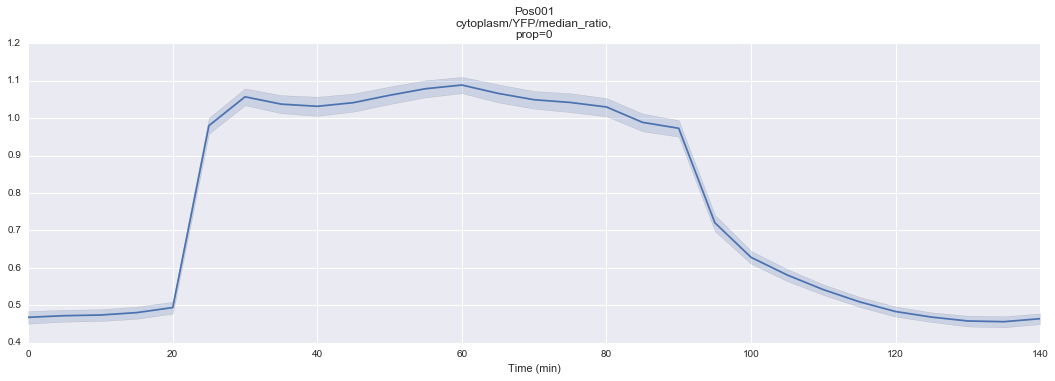

In [6]:
sites.set_state(['cytoplasm', 'YFP', 'median_ratio'])
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)
axes[0].set_xlabel('Time (min)')

You can see the cytoplasmic translocation of the JNK KTR at frame 5 when the cells are stimulated with anisomycin, followed by nuclear translocation at frame 18 when the cells are inhibited with JNK VIII inhibitor.  
This combination of activation and inactivation will provide a large dynamic range, allowing robust parameter estimation. 

Again, we use $k_v = \dfrac{r_{n,2} - r_{n,1}}{r_{c,1} - r_{c,2}}$.  
Let's use the frames between 50 min to 80 min and 90 min to the end for our activated and inhibited conditions, respectively. We can access these data using *site.data* and take the average using the NumPy function *nanmean*.

In [7]:
site = sites.Pos001
time1 = np.array(site.data.time)
r_n_1 = np.nanmean(site.data['nuclei', 'YFP', 'median_intensity'][:, (time1 >= 50) * (time1 <= 80)])
r_n_2 = np.nanmean(site.data['nuclei', 'YFP', 'median_intensity'][:, time1 >= 90])
r_c_1 = np.nanmean(site.data['cytoplasm', 'YFP', 'median_intensity'][:, (time1 >= 50) * (time1 <= 80)])
r_c_2 = np.nanmean(site.data['cytoplasm', 'YFP', 'median_intensity'][:, time1 >= 90])
estimated_k_v = (r_n_2 - r_n_1)/(r_c_1 - r_c_2)
print 'k_v is {0:1.2f}'.format(estimated_k_v)

k_v is 3.23


Using these conditions, we estimate the average $k_v$ to be 3.2.

## Estimation of import and export rate constants: k<sub>iu</sub>, k<sub>eu</sub>, k<sub>ip</sub>, k<sub>ep</sub>

Cytoplasmic translocation of the KTR happens because phosphorylation both decreases the nuclear export rate and increases the nuclear import rate. 
So now we need to find the rate constants for the import ($k_i$) and export ($k_e$) of phosphorylated ($k_p$) and unphosphorylated ($k_u$) reporters.

To estimate these constants, we utilize the fact that JNK KTR AA and EE mutants approximate the unphosphorylated and phosphorylated states of the wild-type JNK KTR, respectively. Since AA and EE mutants are not phosphorylated, we assume that k<sub>e</sub> and k<sub>i</sub> for AA mutants is equal to k<sub>eu</sub> and k<sub>iu</sub>. Similarly, k<sub>e</sub> and k<sub>i</sub>  for EE mutants is equal to k<sub>ep</sub> and k<sub>ip</sub>.

In [8]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos004', 'Pos005']
conditions_mut = ['JNK_AA', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df_cleaned.npz')

Leptomycin B (LMB) is a potent inhibitor of nuclear export. The cells are treated with LMB at 1.5 min for Pos004 and at 28 min for Pos005, leading to a net nuclear translocation in both cases.

[<matplotlib.text.Text at 0x11161f610>, <matplotlib.text.Text at 0x111e11cd0>]

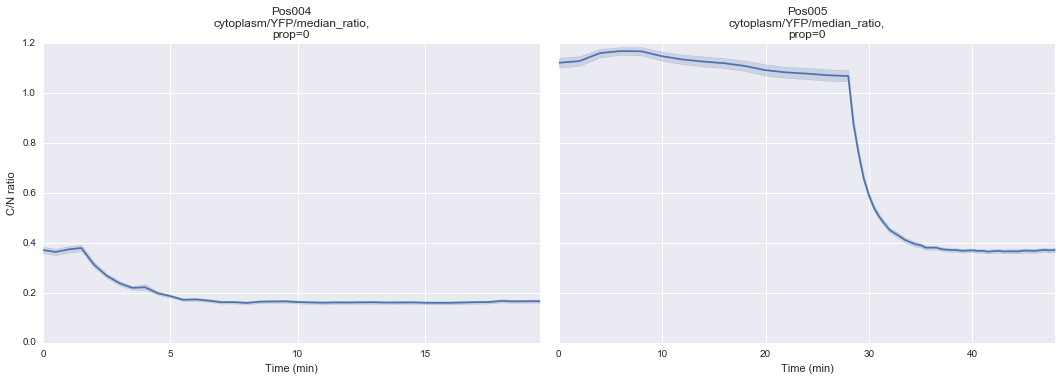

In [9]:
sites_mut.set_state(['cytoplasm', 'YFP', 'median_ratio'])
fig, axes = sites_mut.iterate(plot_tsplot)
axes[0].set_ylabel('C/N ratio')
[ax.set_xlabel('Time (min)') for ax in axes]

In [10]:
aa_ratio = sites_mut.Pos004.data['cytoplasm', 'YFP', 'median_ratio']
ee_ratio = sites_mut.Pos005.data['cytoplasm', 'YFP', 'median_ratio']

We use the following system of differential equations to decribe reporter concentration in the nucleus (r<sub>n</sub>) and cytoplasm (r<sub>c</sub>).

$\dfrac{dr_c}{dt} = -k_i  r_c + k_e  r_n$  
$\dfrac{dr_n}{dt} = k_v  k_i  r_c - k_v  k_e  r_n$

We create a function using *def* that stores these two differential equations and returns the solution given input parameters. Note that *def* only defines the function, but does not run it. We will use a built in ODE solver later to solve this function.

In [11]:
def ode_mutant_model(y, t, *args):
    k_v, k_i, k_e = args[0], args[1], args[2]
    r_c, r_n = y[0], y[1]
    d_r_c = -k_i * r_c + k_e * r_n
    d_r_n = k_v * k_i * r_c - k_v * k_e * r_n
    return [d_r_c, d_r_n]

We assume the efficiency of LMB inhibition varies from cell-to-cell. This is expressed by parameter $h$; upon inhibition at time *t<sub>inh</sub>*, the export rate changes from $k_e$ to $hk_e$.  

The initial steady state of the system is $\dfrac{k_e}{k_i}$, and the steady state after the inhibition will be $\dfrac{hk_e}{k_i}$. 
We can use these values to estimate *h* for each cell.

In [12]:
h_aa, h_ee = [], []
for cell in aa_ratio:
    h_aa.append(np.mean(cell[30:])/np.mean(cell[:3]))
for cell in ee_ratio:
    h_ee.append(np.mean(cell[30:])/np.mean(cell[:12]))

We would like to find the parameters $h$, $k_e$ and $k_i$ such that the model reproduces the time series of the LMB treatment experiment. Write a function that receives $h$, $k_e$ and $k_i$ and returns the predicted time series of the C/N ratio.

We again use *def* to define the function. We also need the SciPy function *odeint* (http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html), which can solve a system of ordinary differential equations. The function containing our ODE model (*ode_mutant_model*) is given as input argument for *odeint*. 

Our function (*calc_ts_sim_ratio*) inputs the parameters from the experiment, then runs *odeint* twice (once for the data before LMB treatment and once for the data after) to solve our ODE model. The returned values are the cytoplasmic/nuclear ratios before and after treatment.

In [13]:
def calc_ts_sim_ratio(x, time, k_v, t_inh, h):
    ei_ratio = x[0]
    k_i = x[1]
    k_e = ei_ratio * k_i
    
    ini_r_c = 1.0
    ini_r_n = 1.0/ei_ratio
    params = (k_v, k_i, k_e)
    # Simulate before inhibition
    ts_pre_inh = odeint(ode_mutant_model, [ini_r_c, ini_r_n], time[time<t_inh], params, rtol=1e-4)
    r_pre_inh = np.array([i[0]/i[1] for i in ts_pre_inh])  # convert reporter profile to cytoplasmic/nuclear ratio
    params = (k_v, k_i, k_e * h)
    # Simulate after inhibition
    ts_post_inh = odeint(ode_mutant_model, [ts_pre_inh[-1, 0], ts_pre_inh[-1, 1]], time[time>=t_inh], params, rtol=1e-4)
    r_post_inh = np.array([i[0]/i[1] for i in ts_post_inh])  # convert reporter profile to cytoplasmic/nuclear ratio
    return np.concatenate((r_pre_inh, r_post_inh))

To begin with, run a simulation just for a single cell with an EE mutant reporter.  
Before stimulation, $\dfrac{k_e}{k_i} = \dfrac{r_c}{r_n}$.

To optimize a fit to the experimental data, we define a cost function as the sum of squared distance between the experimentally measured trace and the estimated trace. We then use the SciPy function [minimize](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.minimize.html) to find values of $k_e$ and $k_i$ that minimize the cost function. Note that in this case we don't use *def* to define the function, but instead use [lambda](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions), which allows the creation of anonymous functions (functions without a name).

In [14]:
bnds = ((1e-6, None), (1e-6, None))  # boundary for h, k_i and k_e
time_ee = np.concatenate((np.arange(0, 28, 2), np.arange(28, 48.5, 0.5)))
t_inh_ee = 27.5

cell_id = 2
first_cell = ee_ratio[cell_id, :]  # time-series of C/N ratio of a cell.

func = lambda x: ((calc_ts_sim_ratio(x, time_ee, estimated_k_v, t_inh_ee, h_ee[cell_id]) - first_cell)**2).sum()  # cost function
ret = minimize(func, x0=[np.mean(first_cell[:1]), 0.1], bounds=bnds, method='L-BFGS-B')  # run the optimization
est_ei_ratio, est_k_i = ret.x  # parameters
est_k_e = est_ei_ratio * est_k_i
print 'k_e and k_i are estimated to be {0:1.3f} and {1:1.3f} for this cell.'.format(est_k_e, est_k_i)

k_e and k_i are estimated to be 0.165 and 0.150 for this cell.


After estimating the parameters, we can compare the predicted time series and experimental time series for this cell.

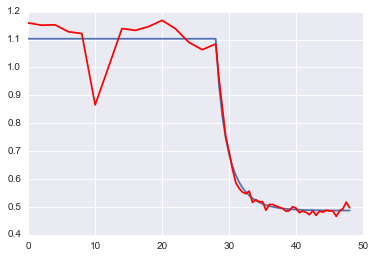

In [15]:
ts_pre_inh = odeint(ode_mutant_model, [est_k_e, est_k_i], time_ee[time_ee<=t_inh_ee],  (estimated_k_v, est_k_i, est_k_e), rtol=1e-4)
ts_post_inh = odeint(ode_mutant_model, [est_k_e, est_k_i], time_ee[time_ee>t_inh_ee],  (estimated_k_v, est_k_i, h_ee[cell_id] * est_k_e), rtol=1e-4)

plt.plot(time_ee, np.concatenate(([i[0]/i[1] for i in ts_pre_inh], [i[0]/i[1] for i in ts_post_inh])))
plt.hold(True)
plt.plot(time_ee, first_cell, 'r');

Now we expand this for all the cells in the experiement using a *for* loop to iterate over the set of cells.

In [16]:
param_ee_store = []
for cell, sc_h in zip(ee_ratio, h_ee):
    func = lambda x: ((calc_ts_sim_ratio(x, time_ee, estimated_k_v, t_inh_ee, sc_h) - cell)**2).sum()
    ret = minimize(func, x0=[np.mean(cell[:3]), 0.1], bounds=bnds, method='L-BFGS-B', tol=1e-12)
    if ret.success:
        param_ee_store.append(ret.x)
est_k_ip = [i[1] for i in param_ee_store]
est_k_ep = [i[0]*i[1] for i in param_ee_store]

Repeat the process and run a simulation for all the cells with AA mutant reporters.  

In [17]:
param_aa_store = []

time_aa = np.arange(0, 40) * 0.5 # /min, Imaged every 30 sec
t_inh_aa = 2.0   # /min, timing of inihibiton
for cell, sc_h in zip(aa_ratio, h_aa):
    func = lambda x: ((calc_ts_sim_ratio(x, time_aa, estimated_k_v, t_inh_aa, sc_h) - cell)**2).sum()
    ret = minimize(func, x0=[np.mean(cell[:3]), 0.1], bounds=bnds, method='L-BFGS-B', tol=1e-12)
    if ret.success:
        param_aa_store.append(ret.x)

est_k_eu = [i[0]*i[1] for i in param_aa_store]
est_k_iu = [i[1] for i in param_aa_store]

k_iu:0.42	k_ip:0.163
k_eu:0.163	k_ep:0.186


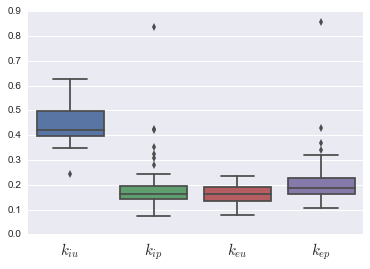

In [18]:
ax = sns.boxplot(data=[est_k_iu, est_k_ip, est_k_eu, est_k_ep])
ax.set_xticklabels(['$k_{iu}$', '$k_{ip}$', '$k_{eu}$', '$k_{ep}$'], fontsize=15);
print "k_iu:{0:1.3}\tk_ip:{1:1.3}\nk_eu:{2:1.3}\tk_ep:{3:1.3}".format(np.nanmedian(est_k_iu), np.nanmedian(est_k_ip), np.nanmedian(est_k_eu), np.nanmedian(est_k_ep))

As expected, you can see that the estimated import rate is larger for unphosphorylated reporters, whereas the export rate is larger for phosphorylated reporters.  
The combination of these effects causes the cytoplasmic translocation of KTRs upon phosphorylation.

## Estimation of dephosphorylation parameters: k<sub>d</sub> and K<sub>md</sub>

After a reporter is phosphorylated, it has to get dephosphorylated by enzymes already present in the cell. k<sub>d</sub> and K<sub>md</sub> are the maximum dephosphorylation rate and Michaelis-Menten constant of reporter dephosphorylation, respectively. Here we assume k<sub>d</sub> is equal in both the cytosol and nucleus.

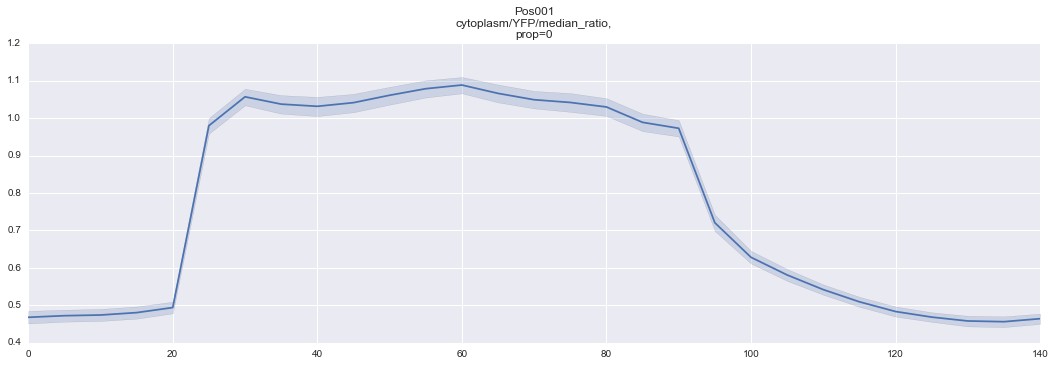

In [19]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)
site = sites.Pos001

We fit $k_d$ and $K_{md}$ to a model such that it reproduces the decay of the C/N ratio after kinase inhibitor treatment at 90 min.
We assume that JNK inhibitor begins inhibition instantly after it is applied to the cells, and that the extent of inhibition varies from cell to cell. 

We are going to use the average import/export rate constants estimated in the previous section. First, make a [dictionary](https://docs.python.org/2.7/tutorial/datastructures.html#dictionaries) containing the parameter set.

In [20]:
param_set = dict(k_v=estimated_k_v, 
                 k_iu=np.nanmedian(est_k_iu), k_eu=np.nanmedian(est_k_eu), 
                 k_ip=np.nanmedian(est_k_ip), k_ep=np.nanmedian(est_k_ep),
                 k_cat=k_cat, Km=Km, r_total=r_total)

Now make a model for the KTR system describing the phosphorylation, dephosphorylation, and nuclear-cytosolic shuttling of the KTR.  


$\dfrac{dr_{cu}}{dt} = -kin_c(t)\cdot k_{cat}\dfrac{r_{cu}}{r_{cu} + K_m} + k_{dc}\cdot \dfrac{r_{cp}}{r_{cp}+K_{md}} - k_{iu}\cdot r_{cu} + k_{eu}\cdot r_{nu}$  
$\dfrac{dr_{nu}}{dt} = -kin_n(t)\cdot k_{cat}\dfrac{r_{nu}}{r_{nu} + K_m} + k_{dn}\cdot \dfrac{r_{np}}{r_{np}+K_{md}} + k_v\cdot k_{iu}\cdot r_{cu} - k_v\cdot k_{eu}\cdot r_{nu}$  
$\dfrac{dr_{cp}}{dt} = kin_c(t)\cdot k_{cat}\dfrac{r_{cu}}{r_{cu} + K_m} - k_{dc}\cdot \dfrac{r_{cp}}{r_{cp}+K_{md}} - k_{ip}\cdot r_{cp} + k_{ep}\cdot r_{np}$  
$\dfrac{dr_{np}}{dt} = kin_n(t)\cdot k_{cat}\dfrac{r_{nu}}{r_{nu} + K_m} - k_{dn}\cdot \dfrac{r_{np}}{r_{np}+K_{md}} + k_v\cdot k_{ip}\cdot r_{cp} - k_v\cdot k_{ep}\cdot r_{np}$  
$r_{cu} + r_{cp} + \frac{1}{k_v} (r_{nu} + r_{np}) = r_{total}$

As before, we save the ODE model in a function.

In [21]:
def main_ode(y, t, p):
    """kin_c_func and kin_n_func are the functions that return the active kinase concentration at time t. 
    """
    c_u, n_u, c_p, n_p = y[0], y[1], y[2], y[3]

    k_v = p['k_v']
    k_iu, k_eu, k_ip, k_ep = p['k_iu'], p['k_eu'], p['k_ip'], p['k_ep']
    k_cat, Km, r_total = p['k_cat'], p['Km'], p['r_total']
    k_dc, k_dn, Kmd = p['k_d'], p['k_d'], p['Kmd']
    kin_c_func, kin_n_func = p['kin_c_func'], p['kin_n_func']

    d_c_u = -kin_c_func(t) * k_cat * c_u/(c_u + Km) + k_dc * c_p/(c_p + Kmd) - k_iu * c_u + k_eu * n_u
    d_n_u = -kin_n_func(t) * k_cat * n_u/(n_u + Km) + k_dn * n_p/(n_p + Kmd) + k_v * k_iu * c_u - k_v * k_eu * n_u
    d_c_p = kin_c_func(t) * k_cat * c_u/(c_u + Km) - k_dc * c_p/(c_p + Kmd) - k_ip * c_p + k_ep * n_p
    d_n_p = r_total - c_u - n_u/k_v - c_p - n_p/k_v
    return [d_c_u, d_n_u, d_c_p, d_n_p]

We assume the system is in steady state before inhibiton, thus at a given C/N ratio, we can calculate the reporter profile ($r_{cu}$, $r_{nu}$, $r_{cp}$, $r_{np}$) such that $\frac{dr}{dt}$ is 0.

First, write a function that will calculate the reporter profile given an active kinase concentration (*calc_rep_profile_at_steady state*). The function estimates the cytosolic and nuclear concentrations of the phosphorylated and unphosphorylated reporters to fit the experimental results at steady state ($\frac{dr}{dt}=0$). We will use the NumPy function [interp](http://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) to do a linear interpolation at the steady-state values to use as our steady-state function.

We also write a second function (*calc_rcn_at_steady_state*) to return the C/N ratio at steady-state.

In [22]:
def calc_rep_profile_at_steady_state(kin, pset):
    """At given kinase concentration and parameters,
    simulate the reporter profile (c_u, n_u, c_p, n_p)
    such that it minimizes sum of squared dy, assuming the pseudo-steady state.
    
    Output: reporter profile
    """
    ub = pset['r_total']
    pset['kin_c_func'] = lambda t: np.interp(t, [0, 1], [float(kin), float(kin)])
    pset['kin_n_func'] = lambda t: np.interp(t, [0, 1], [float(kin), float(kin)])
    x0 = [ub, 0, 0, 0]

    func = lambda y: (np.array(main_ode(y, 0, pset))**2).sum()
    ret = minimize(func, x0=x0, method='Powell', tol=1e-3)
    return ret.x

def calc_rcn_at_steady_state(kin, pset):
    """At given kinase concentration and parameters, simulate the C/N ratio at a steady-state.
    """
    x = calc_rep_profile_at_steady_state(kin, pset)
    return (x[0] + x[2])/(x[1] + x[3])

Next, we write a function (*estim_steady_state_kinase*) that inputs a steady-state C/N ratio and estimates a total kinase concentration (using *calc_rcn_at_steady_state*) that recreates the given steady state C/N ratio.

In [23]:
def estim_steady_state_kinase(rcn, pset, bnd_min=0, bnd_max=None):
    """Given C/N ratio at the steady state, return active kinase concentration.
    """
    func1 = lambda kin1: ((calc_rcn_at_steady_state(kin1, pset) - rcn)**2).sum()
    ret1 = minimize(func1, x0=[0.01], bounds=((bnd_min, bnd_max), ), tol=1e-4)
    return ret1.x[0]

Finally, using the functions that we have just written, we define one more function that will be used to fit the parameters $k_d$ and $K_{md}$. The function needs to estimate the intial (pre-inhibition) and final (post-inhibition) steady state kinase concentrations (using *estim_steady_state_kinase*) and the pre-inhibition reporter profile (using *calc_rep_profile_at_steady_state*). The function then returns an estimate of how the reporter profile changes post inhibition. 

In [24]:
KIN_MAX = 3.0  # ad hoc. Kinase concentration should not be as this high.
def inhibitor_ode(x, time, rcn_init, rcn_final, pset):
    """
    Given k_d, Kmd and C/N ratio at the beginning and at the end, it will simulate the timecourse of C/N ratio.
    """
    pset['k_d'] = x[0]
    pset['Kmd'] = x[1]
    # Calculate initial kinase concentration such that it matches with given C/N ratio (rcn_init).
    kin_ini = estim_steady_state_kinase(rcn_init, pset, bnd_max=KIN_MAX)
    # At given kinase concentration, calculate reporter profiles.
    y0 = calc_rep_profile_at_steady_state(kin_ini, pset)
    # At given rcn_final, calculate kinase concentration at the final steady state.
    kin_after_inh = estim_steady_state_kinase(rcn_final, pset, bnd_max=kin_ini)

    # At time 0, inihibition started. kinase is inactive so it follows kinase (rcn_final)
    # but reporter profile at time 0 follows y0. Calculate cytoplasmic to nuclear times series.
    pset['kin_c_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])
    pset['kin_n_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])
    ts = odeint(main_ode, y0, time, (pset, ), rtol=1e-4)
    return (ts[:, 0] + ts[:, 2])/(ts[:, 1] + ts[:, 3])

Estimating $k_d$ and $K_{md}$ with this model is a difficult task, as these two parameters are heavily dependent on each other. For simplicity, we will fit with the population average time-series as opposed to each single-cell trace in order to save a computation time.

To help generate a good fit, we will first guess the initial values by looping over a log-based parameter range and then subsequently fine tune the intial guess. We use a log-based range to avoid getting trapped in local solutions. Note, that we bound the upper limit of $K_{md}$ as $r_{total}$. We use the NumPy function [logspace](http://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html) to generate an even distribution of initial values and then evaluate the squared distance from the calculated C/N ratio to the actual C/N ratio. The initial values that produce the best result are saved.

In [25]:
med_rcn = np.nanmean(site.data['cytoplasm', 'YFP', 'median_ratio'], axis=0)
rcn_init = np.nanmean(med_rcn[18])
rcn_final = med_rcn[-1]
decay_rcn = med_rcn[18:]

time = np.arange(len(decay_rcn)) * 5  # every 5 min
func = lambda x: ((inhibitor_ode(x, time, rcn_init, rcn_final, param_set) - decay_rcn)**2).sum()  # cost function

kd_range, kmd_range = np.logspace(-2, 0, 5), np.logspace(-2, np.log10(param_set['r_total']), 5)

store = [np.Inf, np.Inf, np.Inf]
for kdi in kd_range:
    for kmdi in kmd_range:
        res = func([kdi, kmdi])
        if store[0] > res:  # if an output from the cost function is smaller than previous ones, update store.
            store = [res, kdi, kmdi]
ini_kd, ini_kmd = store[1], store[2]
print ini_kd, ini_kmd

/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/trace/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.0316227766017 0.159054145753


Now, we can use the *minimize* function to more accurately estimate $k_d$ and $K_{md}$ using the initial guesses we just generated. 

The estimated k_d and Kmd for this cell is 0.031 and 0.159


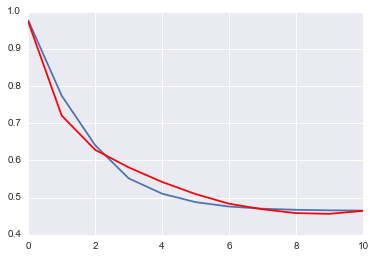

In [26]:
# The estimation of k_d and Kmd for all the single cells takes a time.
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
        {'type': 'ineq', 'fun': lambda x: KIN_MAX - x[0]},
        {'type': 'ineq', 'fun': lambda x: param_set['r_total'] - x[1]})
ret = minimize(func, x0=[ini_kd, ini_kmd], constraints=cons, method='COBYLA', tol=1e-4)
est_k_d, est_Kmd = ret.x[0], ret.x[1]

param_set['k_d'] = est_k_d
param_set['Kmd'] = est_Kmd

plt.plot(inhibitor_ode([est_k_d, est_Kmd], time, rcn_init, rcn_final, param_set))
plt.hold(True)
plt.plot(decay_rcn, 'r')
print 'The estimated k_d and Kmd for this cell is {0:1.3f} and {1:1.3f}'.format(est_k_d, est_Kmd)

## Absolute kinase concentration

Now we have obtained all of the parameters we need to estimate absolute kinase concentration over time. 
First, plot a simulated relationship between the C/N ratio and active JNK at steady state.

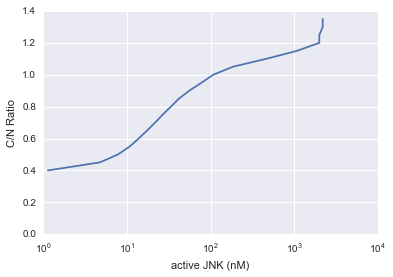

In [27]:
st = []
for i in np.arange(0, 1.4, 0.05):
    st.append(estim_steady_state_kinase(i, param_set) * 1000)  # in nM
plt.semilogx(st, np.arange(0, 1.4, 0.05))
plt.xlabel('active JNK (nM)')
plt.ylabel('C/N Ratio')

You can see that the simulation gets unstable when the amount of active JNK is above 1000 nM.  
Presumably, the model cannot extrapolate past the upper bound of the training data, so we will constrain the upper limit of active JNK to this value for later simulations.  

In [28]:
KIN_MAX = 1.0  # 1uM

Now, let's calculate the time-series of JNK stimulated with IL-1$\beta$. 

In [29]:
parent_folder = join(data_folder, 'IL1B')
sub_folders = ['Pos005', 'Pos006', 'Pos007', 'Pos008']
conditions = ['IL1B', 'IL1B', 'IL1B', 'IL1B']
sites_il1b = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')
sites_il1b.staged.new_file_name = 'merged.npz'
sites_il1b.merge_conditions()

Pos005: file_name is updated to merged.npz


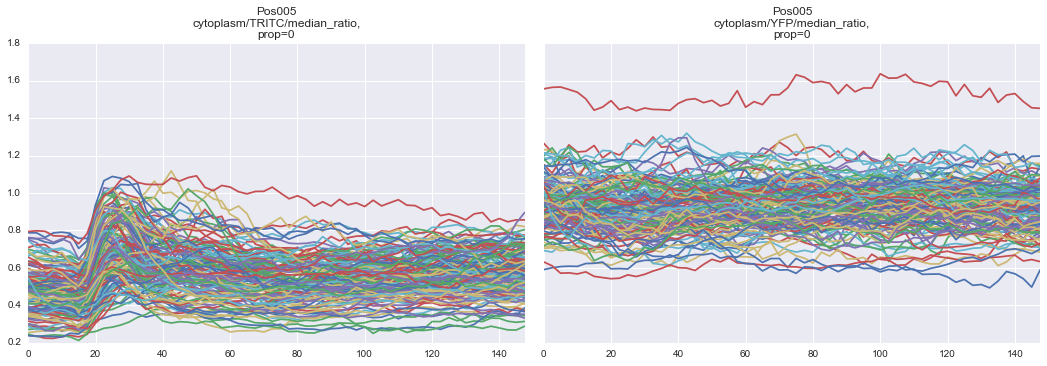

In [30]:
sites_il1b.set_state((['cytoplasm', 'TRITC', 'median_ratio'], ['cytoplasm', 'YFP', 'median_ratio']))
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites_il1b.iterate(plot_all)

In this experiment, cells express the JNK KTR AE mutant (right) in addition to the JNK KTR (left).  
The variability observed in the JNK KTR AE mutant is a reflection of the noise in the endogenous export and import rates. We can use these data to correct for the variability in import and export in individual cells. 

For each cell, we calculate the average C/N ratio over time and then divide it by the average population C/N ratio. This value is *q*, the noise factor in export/import.  
We correct the mean value of the estimated $k_e$ and $k_i$ using $q$ for each cell. 

In [31]:
site_il1b = sites_il1b.Pos005
mean_yfp = np.nanmean(site_il1b.data['cytoplasm', 'YFP', 'median_ratio'], axis=0)
q_store = []
for cell in site_il1b.data['cytoplasm', 'YFP', 'median_ratio']:
    q_store.append(np.mean(cell/mean_yfp))

k_iu_sc, k_ip_sc, k_eu_sc, k_ep_sc = [], [], [], []
for q in q_store:
    k_iu_sc.append(np.nanmean(est_k_iu)/q)
    k_ip_sc.append(np.nanmean(est_k_ip)/q)
    k_eu_sc.append(np.nanmean(est_k_eu) * q)
    k_ep_sc.append(np.nanmean(est_k_ep) * q) 

Now let's start estimation with a single cell.

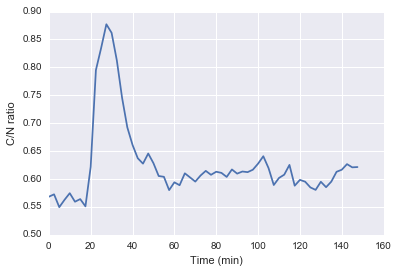

In [32]:
cell_id = 3  # randomly pick one cell
time = np.arange(0, 150, 2.5)  # in minute
single_rcn = site_il1b.data['cytoplasm', 'TRITC', 'median_ratio'][cell_id, :]
plt.plot(time, single_rcn)
plt.ylabel('C/N ratio')
plt.xlabel('Time (min)')

This is the experimental trace that we are going to fit.  

First, to reduce the complexity of parameter estimation, we assume that time-course of active JNK, as well as C/N ratio with IL1-$\beta$ treatment, can be modeled using the trapezoid function below.    
This part might not be necessary but reduces the calculation cost.
<img src="../../data/trapezoid.jpg" width="300">

We write a function, *trapezoid_func*, that stores the linear equation describing each portion of the trapezoid and the times where each section begins and ends.

In [33]:
def trapezoid_func(t, ct1, ct2, ct3, ct4, c1, c2, c3):
    """Trapezoid function.
    ct1 = t1
    ct2 = t1 + t2
    ct3 = t1 + t2 + t3
    ct4 = t1 + t2 + t3 + t4
    
    """
    if t <= ct1:
        return c1
    elif (t > ct1) and (t <= ct2):
        return c1 + (c2 - c1) * (t-ct1)/(ct2-ct1)
    elif (t > ct2) and (t <= ct3):
        return c2
    elif (t > ct3) and (t <= ct4):
        return c2 - (c2 - c3) * (t-ct3)/(ct4-ct3)
    elif t > ct4:
        return c3

Since we assume the data can be fit with the trapezoid function, we would like to capture the dynamics of first peak (mostly ~50 min) in particular.  
Thus, we put some emphasis on the fitting results before 50 min in the following cost function (*trapezoid_err*). This makes fitting to noisy data more robust. The cost function is still the squared distance to the experimental values.

In [34]:
def trapezoid_err(params, t, y, w=5, tw=50):
    """cost function for trapezoid fitting.
    w is picked ad hoc."""
    weights = np.ones(len(t))
    weights[t <= tw] = w
    y_p = np.zeros(y.shape)
    for num, ti in enumerate(t):
        y_p[num] = trapezoid_func(np.float(ti)/t.max(), *params)
    return ((y - y_p)**2 * weights).sum()

We also write a function (*fit_trapezoid*) that will fit whatever input data is given to the trapezoidal function. The function then returns the time points for each of the four stages ($T_1,T_2,T_3,T_4$), as well as the values at each intersection ($C_1, C_2, C_3$). A set of constraints stored in the variable *cons* ensures the fit produced is trapezoidal.

In [35]:
def fit_trapezoid(t, y, p0=None, tbuf=[0.05, 0.05, 0.05]):
    if p0 is None:
        p0 = [0.2, 0.4, 0.6, 0.8, y[0], y.max(), y[-1]]
    # This is the constraints for trapezoid parameters.
    cons = ({'type': 'ineq', 'fun': lambda x:  x[1] - x[0] - tbuf[0]},  # t1 < t2
            {'type': 'ineq', 'fun': lambda x:  x[2] - x[1] - tbuf[1]},  # t2 < t3
            {'type': 'ineq', 'fun': lambda x:  x[3] - x[2] - tbuf[2]},  # t3 < t4
            {'type': 'ineq', 'fun': lambda x:  x[5] - x[4]},  # c1 < c2
            {'type': 'ineq', 'fun': lambda x:  x[5] - x[6]},  # c3 < c2
            {'type': 'ineq', 'fun': lambda x:  x})  # non-negative parameters
    bnds = ((0, 1), ) * 4 + ((y.min(), y.max()), ) * 3
    fun = partial(trapezoid_err, t=t, y=y)
    res = minimize(fun, p0, constraints=cons, bounds=bnds, tol=1e-12, options=dict(max_iter=10000))
    # convert Ts from relative to absolute time.
    Ts = np.interp(res.x[:4], np.linspace(0, 1, len(t)), t)
    return np.concatenate((Ts, res.x[4:]))

To determine the values for $T_1-T_4$, we first fit the time-series of the C/N ratio with the trapezoid function.

/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/trace/lib/python2.7/site-packages/ipykernel/__main__.py:13: OptimizeWarning: Unknown solver options: max_iter


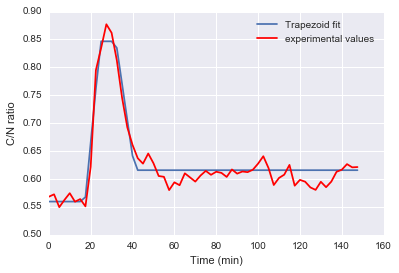

In [36]:
ct1, ct2, ct3, ct4, c1, c2, c3 = fit_trapezoid(time, single_rcn)
kin_func = lambda t: np.interp(t, [ct1, ct2, ct3, ct4, time[-1]], [c1, c2, c2, c3, c3])
plt.plot(time, kin_func(time))
plt.hold(True)
plt.plot(time, single_rcn, 'r')
plt.legend(['Trapezoid fit', 'experimental values'])
plt.ylabel('C/N ratio')
plt.xlabel('Time (min)')

The fitting worked well. 
The *fit_trapezoid* function returns cumulative values (e.g. $C_{T_2} = C_{T_1} + C_{T_2}$), so now we write functions that converts the cumulative values to absolute values (*normt1_to_ct1* and *ct1_to_normt1*).  
Note that $T_1-T_4$ are normalized by the last time point to have a scale from 0 to 1.  

In [37]:
def normt1_to_ct1(rt1, rt2, rt3, rt4, time):
    """convert normalized t1 to cumulative time."""
    ct1 = rt1 * time[-1]
    ct2 = (rt1 + rt2) * time[-1]
    ct3 = (rt1 + rt2 + rt3) * time[-1]
    ct4 = (rt1 + rt2 + rt3 + rt4) * time[-1]
    return ct1, ct2, ct3, ct4

def ct1_to_normt1(ct1, ct2, ct3, ct4, time):
    """convert cumulative time to normalized t1."""
    t1 = ct1/time[-1]
    t2 = (ct2 - ct1)/time[-1]
    t3 = (ct3 - ct2)/time[-1]
    t4 = (ct4 - ct3)/time[-1]
    return t1, t2, t3, t4

ini_t1, ini_t2, ini_t3, ini_t4 = ct1_to_normt1(ct1, ct2, ct3, ct4, time)  # initial values
print 'The initial values for T1, T2, T3 and T4 are {0:0.1f}, {1:0.1f}, {2:0.1f} and {3:0.1f} min.'.format(ini_t1*time[-1], ini_t2*time[-1], ini_t3*time[-1], ini_t4*time[-1])

The initial values for T1, T2, T3 and T4 are 17.3, 7.4, 7.4 and 9.0 min.


Now that we have our time values estimated, we can try fitting our ODE model (*main_ode*) from before. The function *kinase_dyanmics_ode* fits the reporter profile to the trapezoidal function. The function *rcn_dynamics_ode* uses these values to generate the C/N ratio.

In [38]:
def kinase_dynamics_ode(kins, time, pset, k1):
    """receives kinase concentration corresponding to C1, C2 and C3 and run a simulation based on those."""
    k2, k3, t1, t2, t3, t4 = kins
    # get model to steady state
    rep0 = calc_rep_profile_at_steady_state(k1, pset)
    ct1, ct2, ct3, ct4 = normt1_to_ct1(t1, t2, t3, t4, time)
    t_kins = [ct1, ct2, ct3, ct4, time[-1]]
    
    pset['kin_c_func'] = lambda t: np.interp(t, t_kins, [k1, k2, k2, k3, k3])
    pset['kin_n_func'] = lambda t: np.interp(t, t_kins, [k1, k2, k2, k3, k3])
    ts = odeint(main_ode, rep0, time, (pset, ))
    return ts

def rcn_dynamics_ode(kins, time, pset, k1):
    rep = kinase_dynamics_ode(kins, time, pset, k1)
    return (rep[:, 0] + rep[:, 2])/(rep[:, 1] + rep[:, 3])

Set the corrected import and export rate constants for this cell to the param_set.

In [39]:
param_set['k_iu'] = k_iu_sc[cell_id]
param_set['k_ip'] = k_ip_sc[cell_id]
param_set['k_eu'] = k_eu_sc[cell_id]
param_set['k_ep'] = k_ep_sc[cell_id]

We assume that the initial and final C/N ratio are pseudo-steady state and use them to estimate the initial and final kinase concentration.

In [40]:
kin_ini = estim_steady_state_kinase(single_rcn[0], param_set, bnd_max=KIN_MAX)  
kin_fin = estim_steady_state_kinase(c3, param_set, bnd_max=KIN_MAX)

Again, we define a cost function which minimizes the difference between the experimental time-series and the simulated time-series.

In [41]:
func = lambda x: ((rcn_dynamics_ode(x, time, param_set, kin_ini) - single_rcn)**2).sum()

Recall that we derived initial values for $T_1-T_4$ are by fitting the trapezoid function to the C/N ratio data. However, kinase activation precedes any change in the C/N ratio, so to find the actual $T_1-T_4$ values, we use *minimize* to optimize the *rcn_dynamics_ode* function, with $T_1-T_4$ bounded by the values from the C/N data.

In [42]:
bnds = ((0, 1), (0, 1), (0, ini_t1), (0, ini_t2), (0, ini_t3), (0, ini_t4))
ret = minimize(func, x0=(kin_fin*2, kin_fin, ini_t1, ini_t2, ini_t3, ini_t4), bounds=bnds, method='L-BFGS-B')

We can now plot our estimated kinase concentrations and the simulated C/N ratios that would result from those concentrations and see that they closely match the measured C/N ratios.

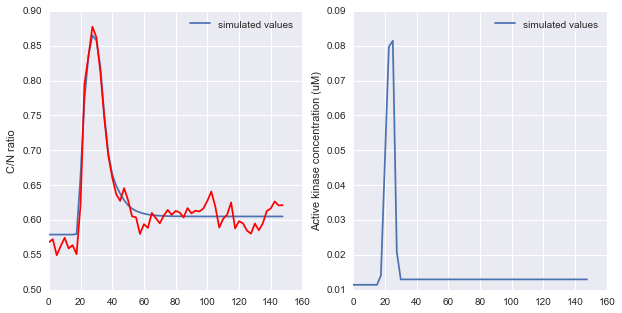

In [43]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
h1 = plt.plot(time, rcn_dynamics_ode(ret.x, time, param_set, kin_ini))
plt.hold(True)
h2 = plt.plot(time, single_rcn, 'r')
ax1.set_ylabel('C/N ratio')
ax1.legend(h1, ['simulated values'])

ax2 = fig.add_subplot(1,2,2)
ct1, ct2, ct3, ct4 = normt1_to_ct1(ret.x[2], ret.x[3], ret.x[4], ret.x[5], time)
kin_ts = np.interp(time, [ct1, ct2, ct3, ct4, time[-1]], [kin_ini, ret.x[0], ret.x[0], ret.x[1], ret.x[1]])
h3 = plt.plot(time, kin_ts)
ax2.set_ylabel('Active kinase concentration (uM)')
ax2.legend(h3, ['simulated values'])

Now, we compile all of the steps above into a function (*estim_kin_ts*) so that we can easily apply this process to estimate the dynamic kinase concentration for many cells.

In [44]:
# Put the steps above into this.
def estim_kin_ts(time, single_rcn, pset, k_iu, k_ip, k_eu, k_ep):
    ct1, ct2, ct3, ct4, c1, c2, c3 = fit_trapezoid(time, single_rcn)
    pset['k_iu'] = k_iu
    pset['k_ip'] = k_ip
    pset['k_eu'] = k_eu
    pset['k_ep'] = k_ep
    kin_ini = estim_steady_state_kinase(c1, pset, bnd_max=KIN_MAX)
    kin_fin = estim_steady_state_kinase(c3, pset, bnd_max=KIN_MAX)
    
    func = lambda x: ((rcn_dynamics_ode(x, time, param_set, kin_ini) - single_rcn)**2).sum()
    bnds = ((0, 1), (0, 1), (0, ini_t1), (0, ini_t2), (0, ini_t3), (0, ini_t4))
    ret = minimize(func, x0=(kin_fin*3, kin_fin, ini_t1, ini_t2, ini_t3, ini_t4), bounds=bnds, method='L-BFGS-B', tol=1e-4)

    estim_rcn = rcn_dynamics_ode(ret.x, time, param_set, kin_ini)
    ct1, ct2, ct3, ct4 = normt1_to_ct1(ret.x[2], ret.x[3], ret.x[4], ret.x[5], time)
    estim_kin = np.interp(time, [ct1, ct2, ct3, ct4, time[-1]], [kin_ini, ret.x[0], ret.x[0], ret.x[1], ret.x[1]])
    return estim_rcn, estim_kin

We simulate for five cells to see that our function works well and that the predictions closely match the experimental data. 

0 estimating...


/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/trace/lib/python2.7/site-packages/ipykernel/__main__.py:13: OptimizeWarning: Unknown solver options: max_iter


1 estimating...
2 estimating...
3 estimating...
4 estimating...


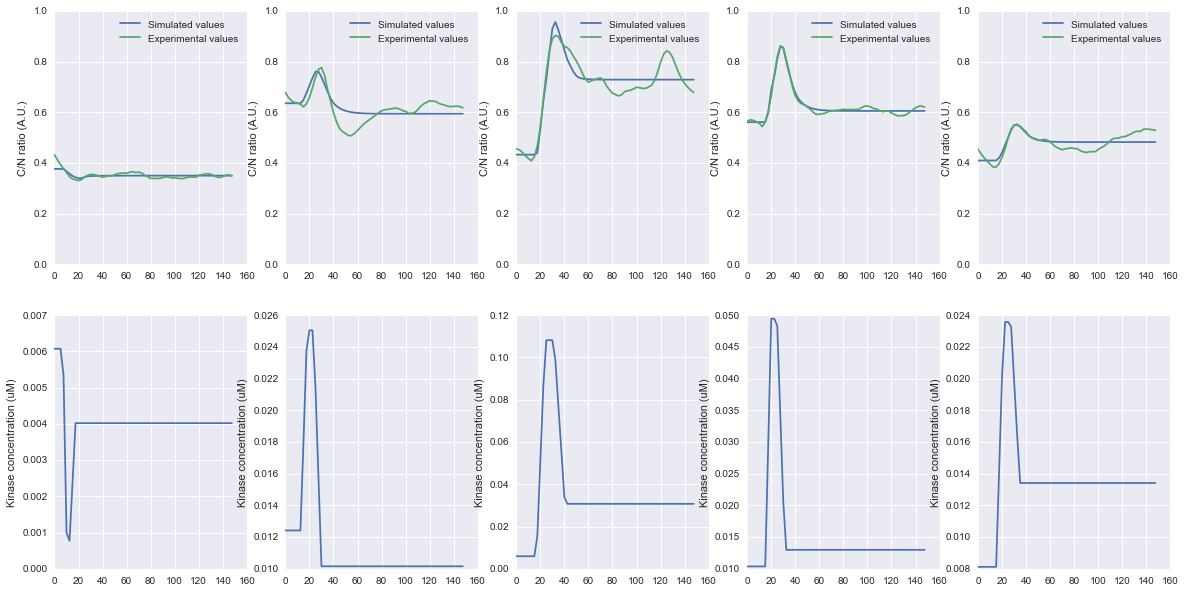

In [48]:
plt.figure(figsize=(20, 10))
median_ratio = site_il1b.data['cytoplasm', 'TRITC', 'median_ratio']
median_ratio = savgol_filter(median_ratio, window_length=9, polyorder=3, axis=1)  # smoothing
cell_ids = range(5)
for num, cell_id in enumerate(cell_ids):
    single_rcn = median_ratio[cell_id]
    print '{0} estimating...'.format(cell_id)
    estim_rcn, estim_kin = estim_kin_ts(time, single_rcn, param_set,  k_iu_sc[cell_id], k_ip_sc[cell_id], k_eu_sc[cell_id], k_ep_sc[cell_id])
    ax1 = plt.subplot(2, 5, num+1)
    h1 = plt.plot(time, estim_rcn, time, single_rcn)
    ax1.set_ylabel('C/N ratio (A.U.)')
    ax1.set_ylim([0, 1])
    ax1.legend(h1, ['Simulated values', 'Experimental values'])
    ax2 = plt.subplot(2, 5, num+1+5)
    plt.plot(time, estim_kin)
    ax2.set_ylabel('Kinase concentration (uM)')

Finally, we can run the simulation for all of the cells. Note that this process may take a while (~30 minutes).

In [49]:
# Store estimated C/N ratio and estimated active JNK in store
store = []
cell_ids = range(median_ratio.shape[0])
for num, cell_id in enumerate(cell_ids):
    single_rcn = median_ratio[cell_id]
#     print '{0} estimating...'.format(cell_id)
    estim_rcn, estim_kin = estim_kin_ts(time, single_rcn, param_set,  k_iu_sc[cell_id], k_ip_sc[cell_id], k_eu_sc[cell_id], k_ep_sc[cell_id])    
    store.append((single_rcn, estim_rcn, estim_kin))

/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/trace/lib/python2.7/site-packages/ipykernel/__main__.py:13: OptimizeWarning: Unknown solver options: max_iter


In [50]:
# get rid of those did not fit well.
cleaned_data = [i for i in store if (np.abs(i[1] - i[0])).sum() < 2.5]

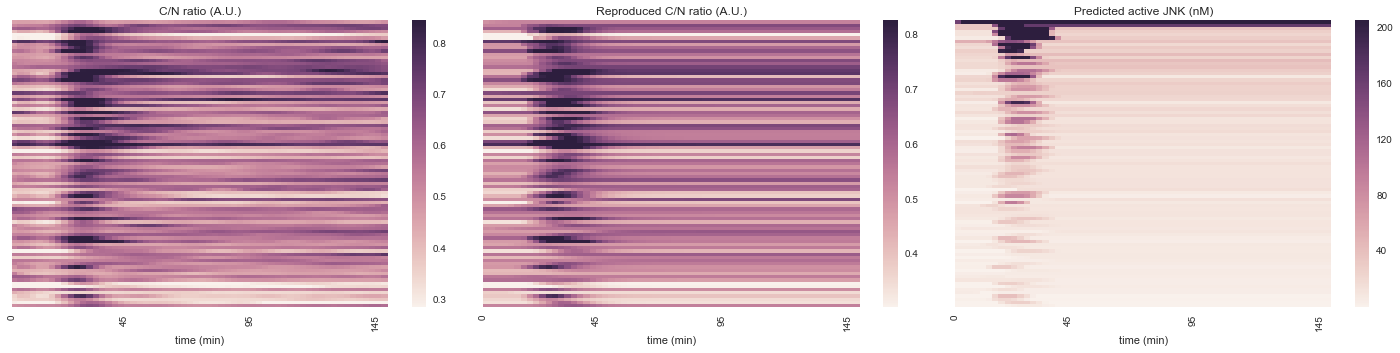

In [52]:
idx = np.argsort(-np.sum([i[2] for i in cleaned_data], axis=1))
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes.tolist()
sns.heatmap([cleaned_data[i][0] for i in idx], robust=True, ax=axes[0])
sns.heatmap([cleaned_data[i][1] for i in idx], robust=True, ax=axes[1])
sns.heatmap([cleaned_data[i][2]*1000 for i in idx], robust=True, ax=axes[2])
[ax.set_title(i) for ax, i in zip(axes, ('C/N ratio (A.U.)', 'Reproduced C/N ratio (A.U.)', 'Predicted active JNK (nM)'))];
[ax.set_yticklabels("") for ax in axes];
[ax.set_xticks([0, 18, 38, 58]) for ax in axes];
[ax.set_xticklabels([int(time[0]), int(time[18]), int(time[38]), int(time[58])]) for ax in axes];
[ax.set_xlabel("time (min)") for ax in axes];
fig.tight_layout()
fig.savefig('heatmap.svg', format='svg', dpi=1200)